In [38]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats

In [120]:
df = pd.read_csv("QF632_Project_1.csv")
df["Date"] = pd.to_datetime(df["Date"])

# Review Data Quality

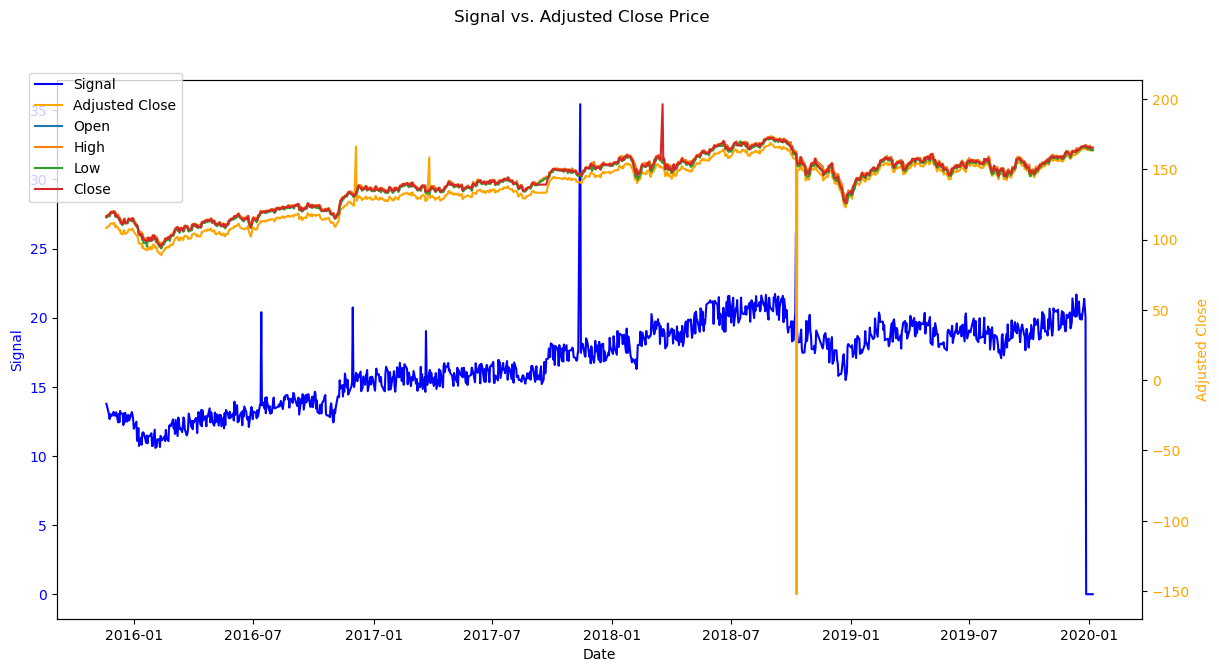

In [40]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Signal on the primary y-axis
ax1.plot(df['Date'], df['Signal'], label='Signal', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Signal', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis and plot the Adjusted Close on it
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Adj Close'], label='Adjusted Close', color='orange')
ax2.plot(df['Date'], df['Open'], label='Open')
ax2.plot(df['Date'], df['High'], label='High')
ax2.plot(df['Date'], df['Low'], label='Low')
ax2.plot(df['Date'], df['Close'], label='Close')
ax2.set_ylabel('Adjusted Close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title and a legend
fig.suptitle('Signal vs. Adjusted Close Price')
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()

## missing value

In [41]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values:\n", missing_values)

Missing values:
 Date         0
Signal       0
Open         0
High         0
Low          0
Close        0
Adj Close    0
dtype: int64


## Outliers:

In [42]:
# Detect outliers using z-score
z_scores = stats.zscore(df.select_dtypes(include=[float, int]))
abs_z_scores = np.abs(z_scores)
outliers = (abs_z_scores > 3).all(axis=1)
print("Outliers:\n", df[outliers])

# # Example correction: Remove outliers
# df = df[~outliers]

Outliers:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


## Data Type Mismatches

In [43]:
# Check data types
print("Data types before correction:\n", df.dtypes)

Data types before correction:
 Date         datetime64[ns]
Signal              float64
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
dtype: object


## Duplicate Records

In [44]:
# Check for duplicate rows
duplicates = df.duplicated()
print("Duplicate rows:\n", df[duplicates])

# # Example correction: Remove duplicate rows
# df = df.drop_duplicates()

Duplicate rows:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


In [45]:
# Check for values outside expected range
inconsistent_values = df[(df['Signal'] <= 0) | (df['Adj Close'] <= 0)]
print("Inconsistent values:\n", inconsistent_values)
# # Example correction: Cap negative values at zero
# df['Signal'] = df['Signal'].clip(lower=0)
# df['Adj Close'] = df['Adj Close'].clip(lower=0)

Inconsistent values:
            Date     Signal        Open        High         Low       Close  \
732  2018-10-10  19.719477  160.820007  160.990005  156.360001  156.559998   
1032 2019-12-27   0.000000  167.119995  167.119995  165.429993  165.860001   
1033 2019-12-30   0.000000  165.979996  166.210007  164.570007  165.440002   
1034 2019-12-31   0.000000  165.080002  166.350006  164.710007  165.669998   
1035 2020-01-02   0.000000  166.740005  166.750000  164.229996  165.779999   
1036 2020-01-03   0.000000  163.740005  165.410004  163.699997  165.130005   
1037 2020-01-06   0.000000  163.850006  165.539993  163.539993  165.350006   

       Adj Close  
732  -152.277847  
1032  164.039063  
1033  163.623688  
1034  163.851135  
1035  163.959946  
1036  163.317093  
1037  163.534668  


# Correct Errors

In [121]:
df.at[732,"Adj Close"] = 152.277847
df = df[df['Signal'] != 0]

## range error

In [122]:
def correct_price_ranges(row):
    prices = {
        'Open': row['Open'],
        'High': row['High'],
        'Low': row['Low'],
        'Close': row['Close']
    }
    
    # Find the correct high and low values
    correct_high = max(prices.values())
    correct_low = min(prices.values())
    
    # Identify which keys (Open, High, Low, Close) have the max and min values
    max_key = next(key for key, value in prices.items() if value == correct_high)
    min_key = next(key for key, value in prices.items() if value == correct_low)
    
    # Swap values to ensure high is max and low is min
    for key in prices:
        if prices[key] == correct_high and key != 'High':
            prices[key], prices['High'] = prices['High'], prices[key]
    for key in prices:
        if prices[key] == correct_low and key != 'Low':
            prices[key], prices['Low'] = prices['Low'], prices[key]
    
    # Update the row with corrected values
    row['Open'] = prices['Open']
    row['High'] = prices['High']
    row['Low'] = prices['Low']
    row['Close'] = prices['Close']

    
    return row

# Apply the correction function to each row in the DataFrame
df = df.apply(correct_price_ranges, axis=1)

In [123]:
# Identify rows where High is less than Low
high_low_inconsistent = df[df['High'] < df['Low']]
print("Rows with inconsistent High and Low:\n", high_low_inconsistent)

# Swap High and Low values where High is less than Low
df.loc[df['High'] < df['Low'], ['High', 'Low']] = df.loc[df['High'] < df['Low'], ['Low', 'High']].values

# Verify the correction
high_low_inconsistent_after = df[df['High'] < df['Low']]
print("Rows with inconsistent High and Low after correction:\n", high_low_inconsistent_after)

Rows with inconsistent High and Low:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []
Rows with inconsistent High and Low after correction:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


In [124]:
# Verify the Close price correction
inconsistent_data = df[(df['Close'] < df['Low']) | (df['Close'] > df['High'])]
print("Inconsistent data:\n", inconsistent_data)

df.loc[df['Close'] < df['Low'], 'Close'] = df['Low']
df.loc[df['Close'] > df['High'], 'Close'] = df['High']

# Verify the Close price correction
inconsistent_data_after = df[(df['Close'] < df['Low']) | (df['Close'] > df['High'])]
print("Inconsistent data after correction:\n", inconsistent_data_after)

Inconsistent data:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []
Inconsistent data after correction:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


In [125]:
# Verify the Open price correction
inconsistent_data = df[(df['Open'] < df['Low']) | (df['Open'] > df['High'])]
print("Inconsistent data:\n", inconsistent_data)

df.loc[df['Open'] < df['Low'], 'Open'] = df['Low']
df.loc[df['Open'] > df['High'], 'Open'] = df['High']

# Verify the Open price correction
inconsistent_data_after = df[(df['Open'] < df['Low']) | (df['Open'] > df['High'])]
print("Inconsistent data after correction:\n", inconsistent_data_after)

Inconsistent data:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []
Inconsistent data after correction:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


In [13]:
threshold = df['Adj Close'].std()  # Using standard deviations as an example

# Identify rows where Adj Close is significantly higher than Close
adj_close_high_errors = df[df['Adj Close'] > df['Close'] + threshold]
print("Rows with high Adj Close errors:\n", adj_close_high_errors)

for i in adj_close_high_errors.index:
    if i > 0:  # Ensure it's not the first row to avoid index out of bounds
        previous_gap = df.loc[i-1, 'Adj Close'] - df.loc[i-1, 'Close']
        df.loc[i, 'Adj Close'] = df.loc[i, 'Close'] + previous_gap

adj_close_high_errors_after = df[df['Adj Close'] > df['Close'] + threshold]
print("Rows with high Adj Close errors after correction:\n", adj_close_high_errors_after)

Rows with high Adj Close errors:
           Date     Signal        Open        High         Low       Close  \
262 2016-12-05  16.011011  131.970001  133.330002  131.889999  133.149994   
338 2017-03-27  16.032241  132.759995  135.070007  132.399994  134.740005   

      Adj Close  
262  166.175079  
338  158.577637  
Rows with high Adj Close errors after correction:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


In [14]:
def correct_signal(df):
    window_size = 20

    # Calculate the rolling mean
    rolling_mean = df['Signal'].rolling(window=window_size, center=True).mean()
    
    # Identify abnormal signals
    signal_errors = (df['Signal'] - rolling_mean).abs() > df['Signal'].std()
    print("Signal errors:\n", df[signal_errors])
    
    for i in signal_errors[signal_errors].index:
        if 0 < i < len(df) - 1:  # Ensure it's not the first or last row to avoid index out of bounds
            prev_signal = df.loc[i - 1, 'Signal']
            next_signal = df.loc[i + 1, 'Signal']
            df.loc[i, 'Signal'] = np.median([prev_signal, next_signal])
    return df



# Correct the Signal values
df = correct_signal(df)

# # Verify the correction
window_size = 20

# Calculate the rolling mean
rolling_mean = df['Signal'].rolling(window=window_size, center=True).mean()

# Identify abnormal signals
signal_errors = (df['Signal'] - rolling_mean).abs() > df['Signal'].std()
print("Signal errors:\n", df[signal_errors])

Signal errors:
           Date     Signal        Open        High         Low       Close  \
161 2016-07-13  20.395083  120.330002  120.389999  118.949997  119.250000   
259 2016-11-30  20.738650  132.919998  133.089996  131.500000  131.610001   
335 2017-03-22  19.029316  133.710007  134.309998  132.779999  134.000000   
500 2017-11-13  35.434147  145.929993  146.820007  145.500000  146.610001   
731 2018-10-09  26.124873  161.619995  162.740005  160.979996  161.190002   

      Adj Close  
161  112.691780  
259  124.715752  
335  127.504295  
500  140.849274  
731  156.781219  
Signal errors:
 Empty DataFrame
Columns: [Date, Signal, Open, High, Low, Close, Adj Close]
Index: []


## the Signal column having zero values

Impute Missing Values:forward fill, backward fill, or interpolation

Remove Rows with Zero Signal

Replace with Statistical Measures:
You can replace the zero values with the mean or median of the Signal column

## potential error from Adj close

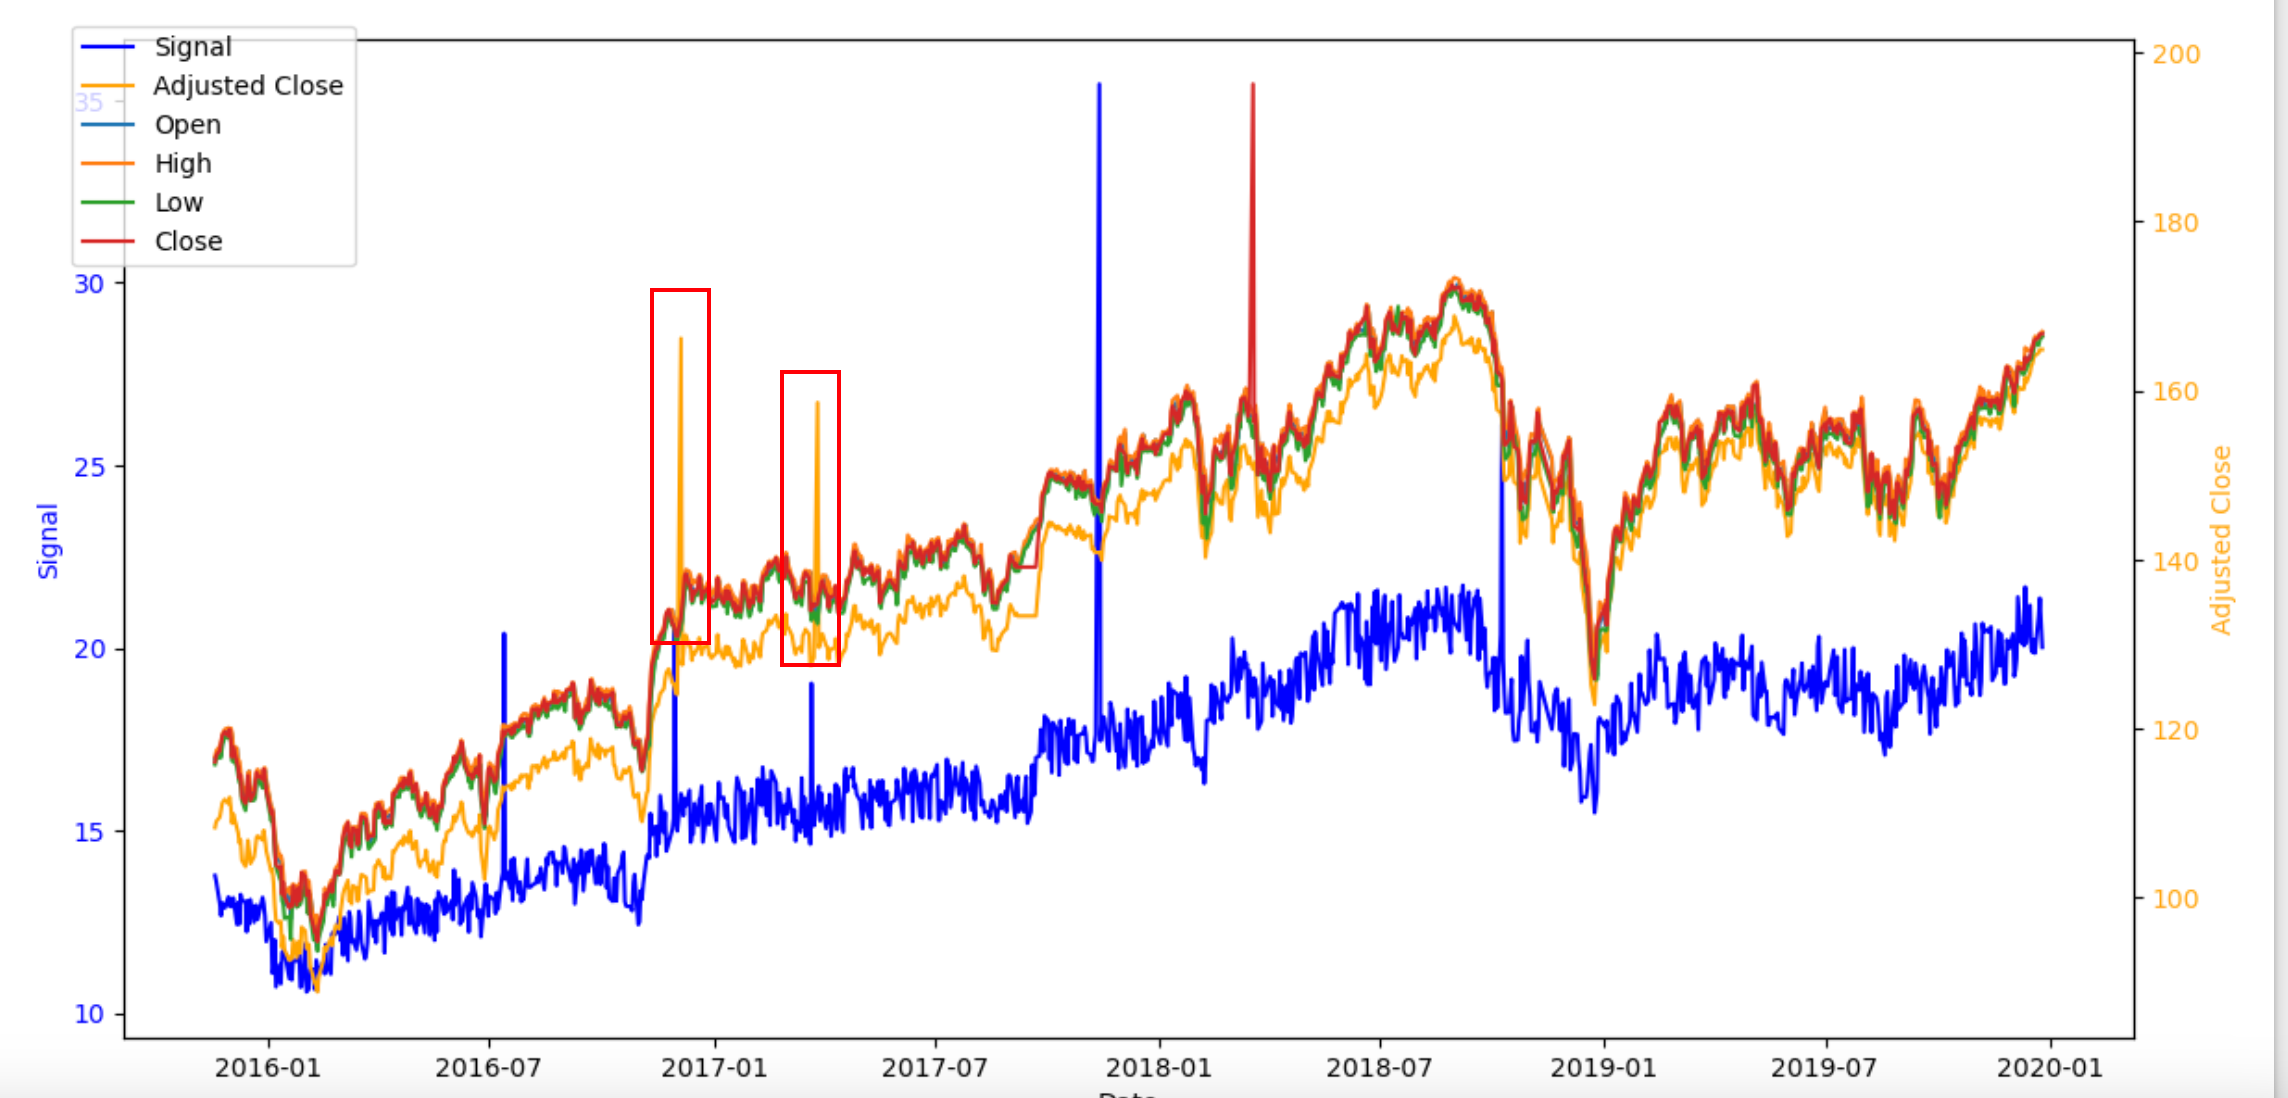

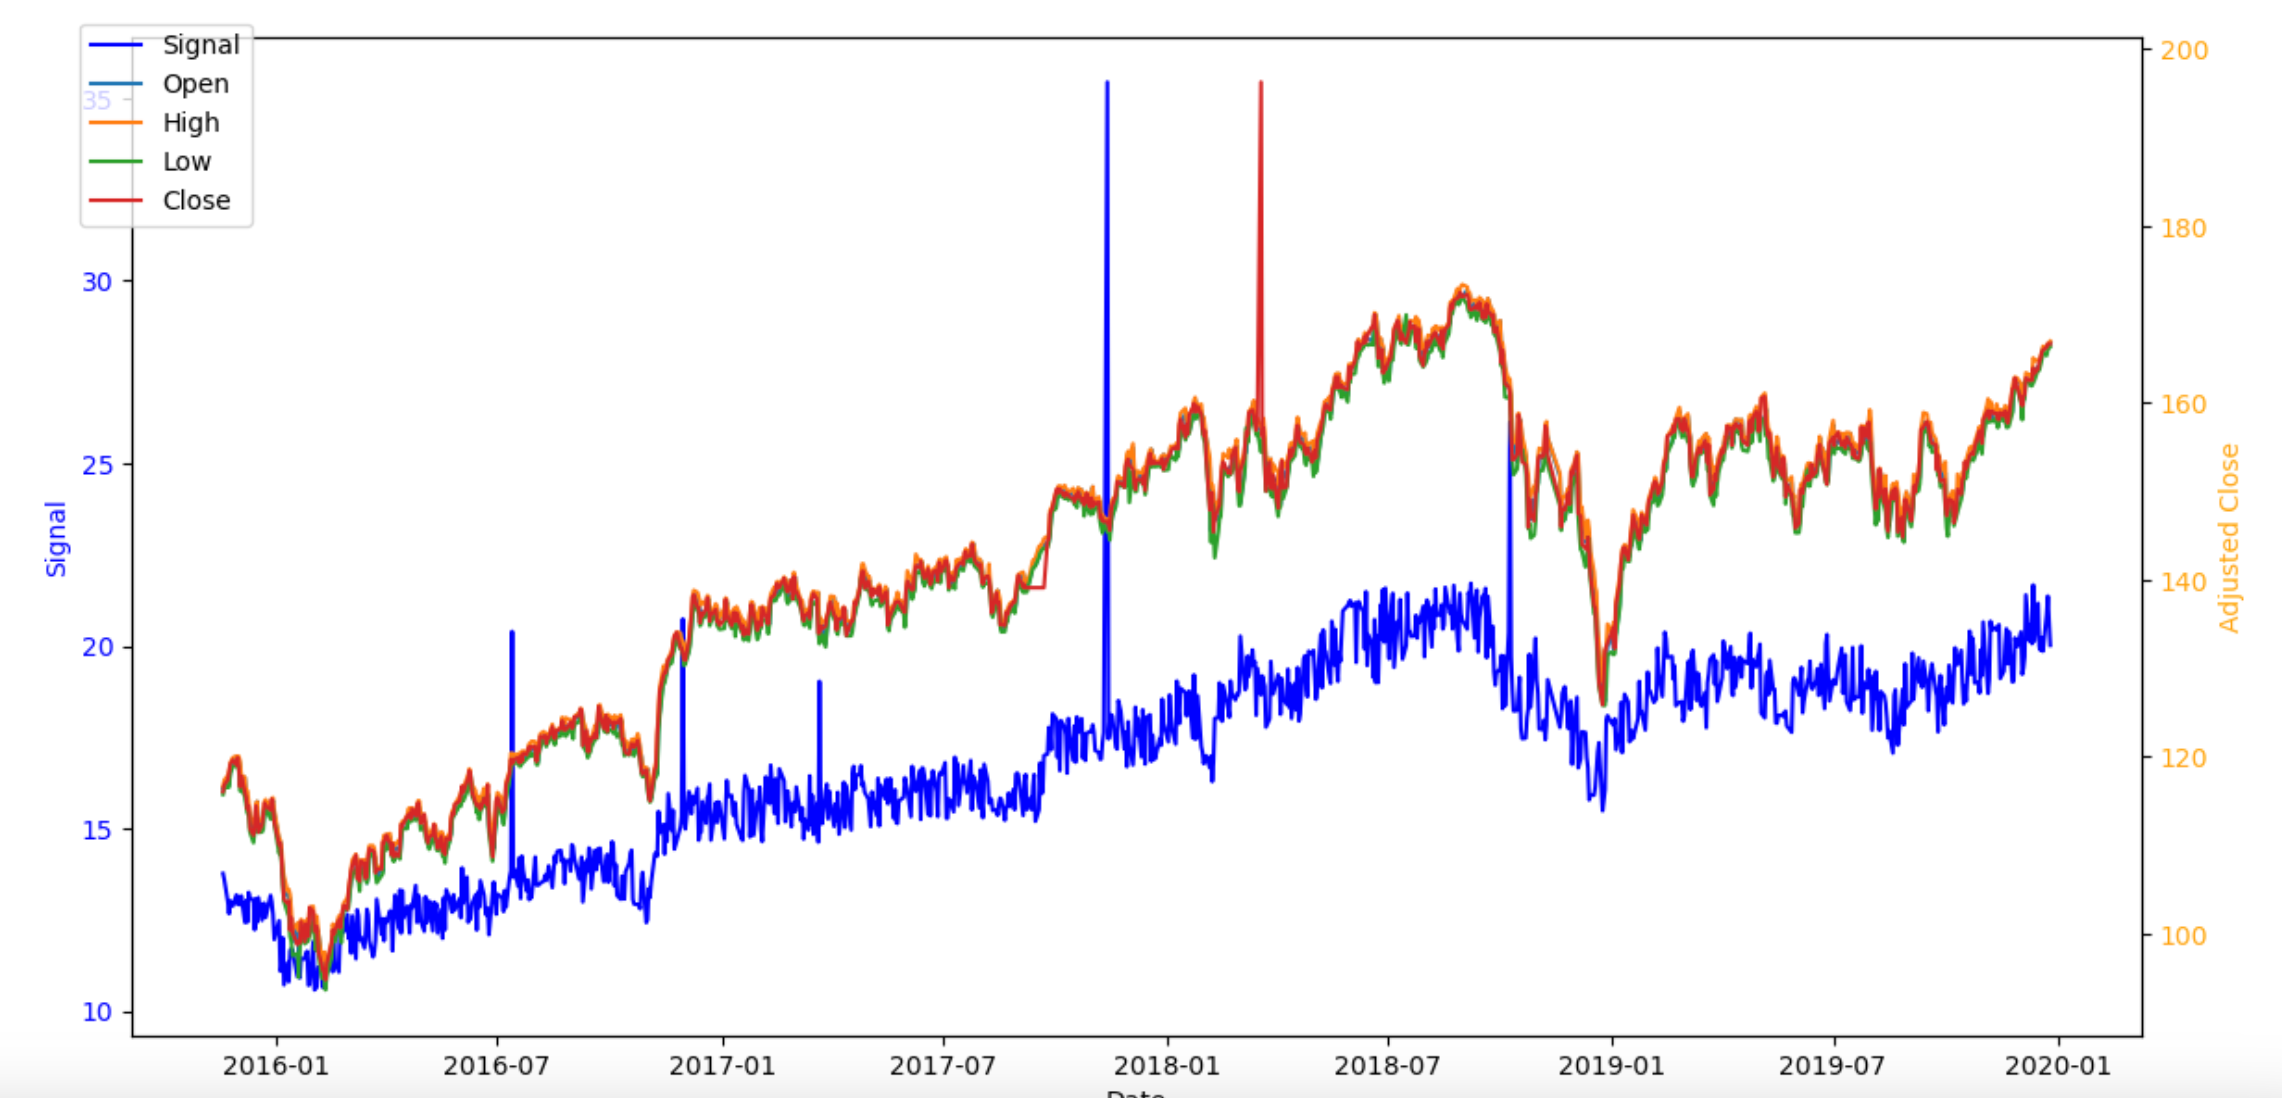

# potential error from close price

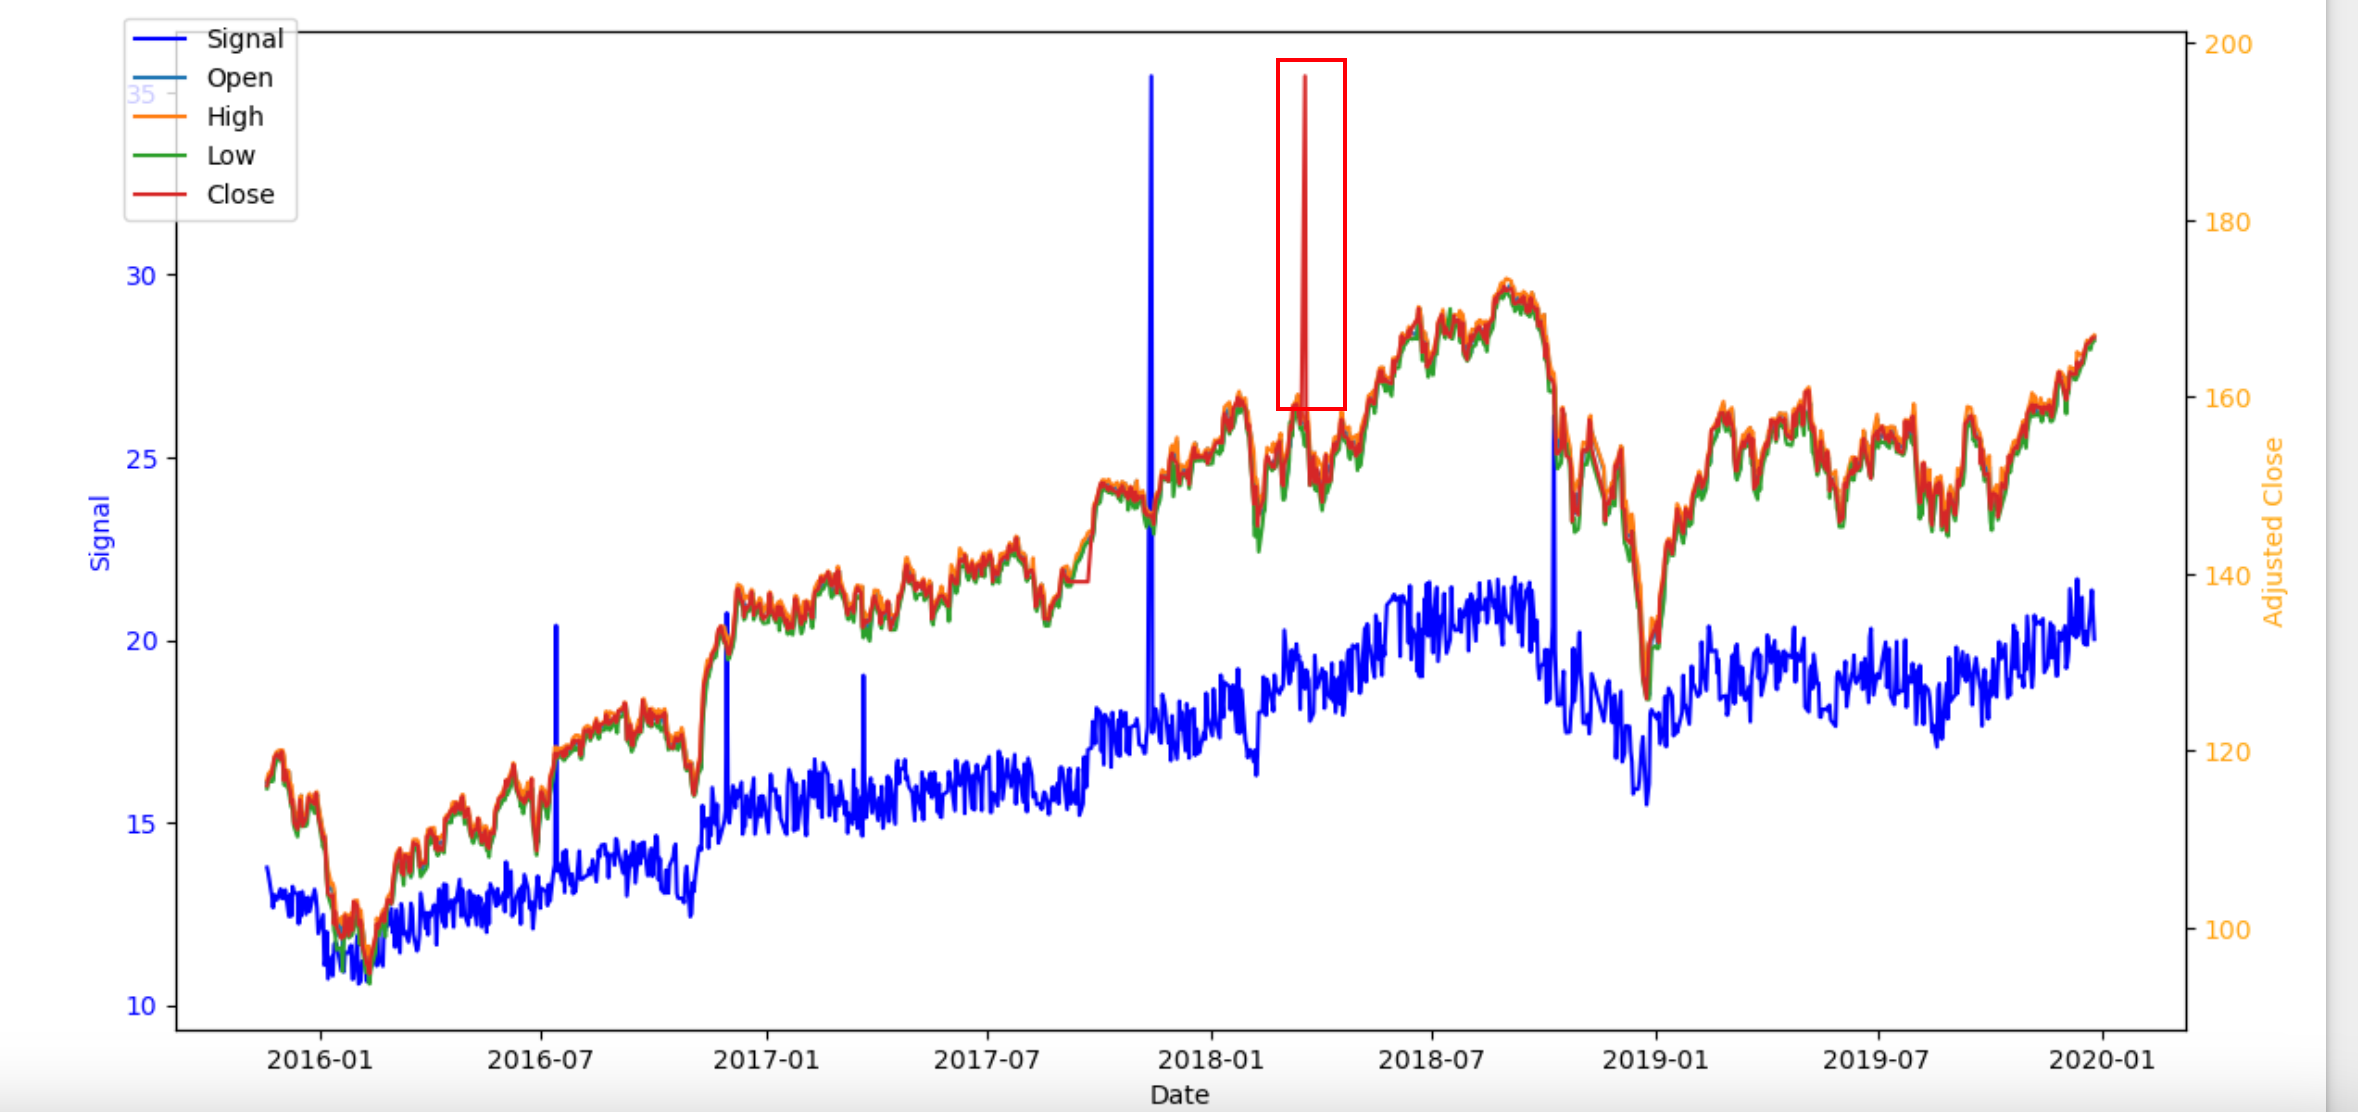

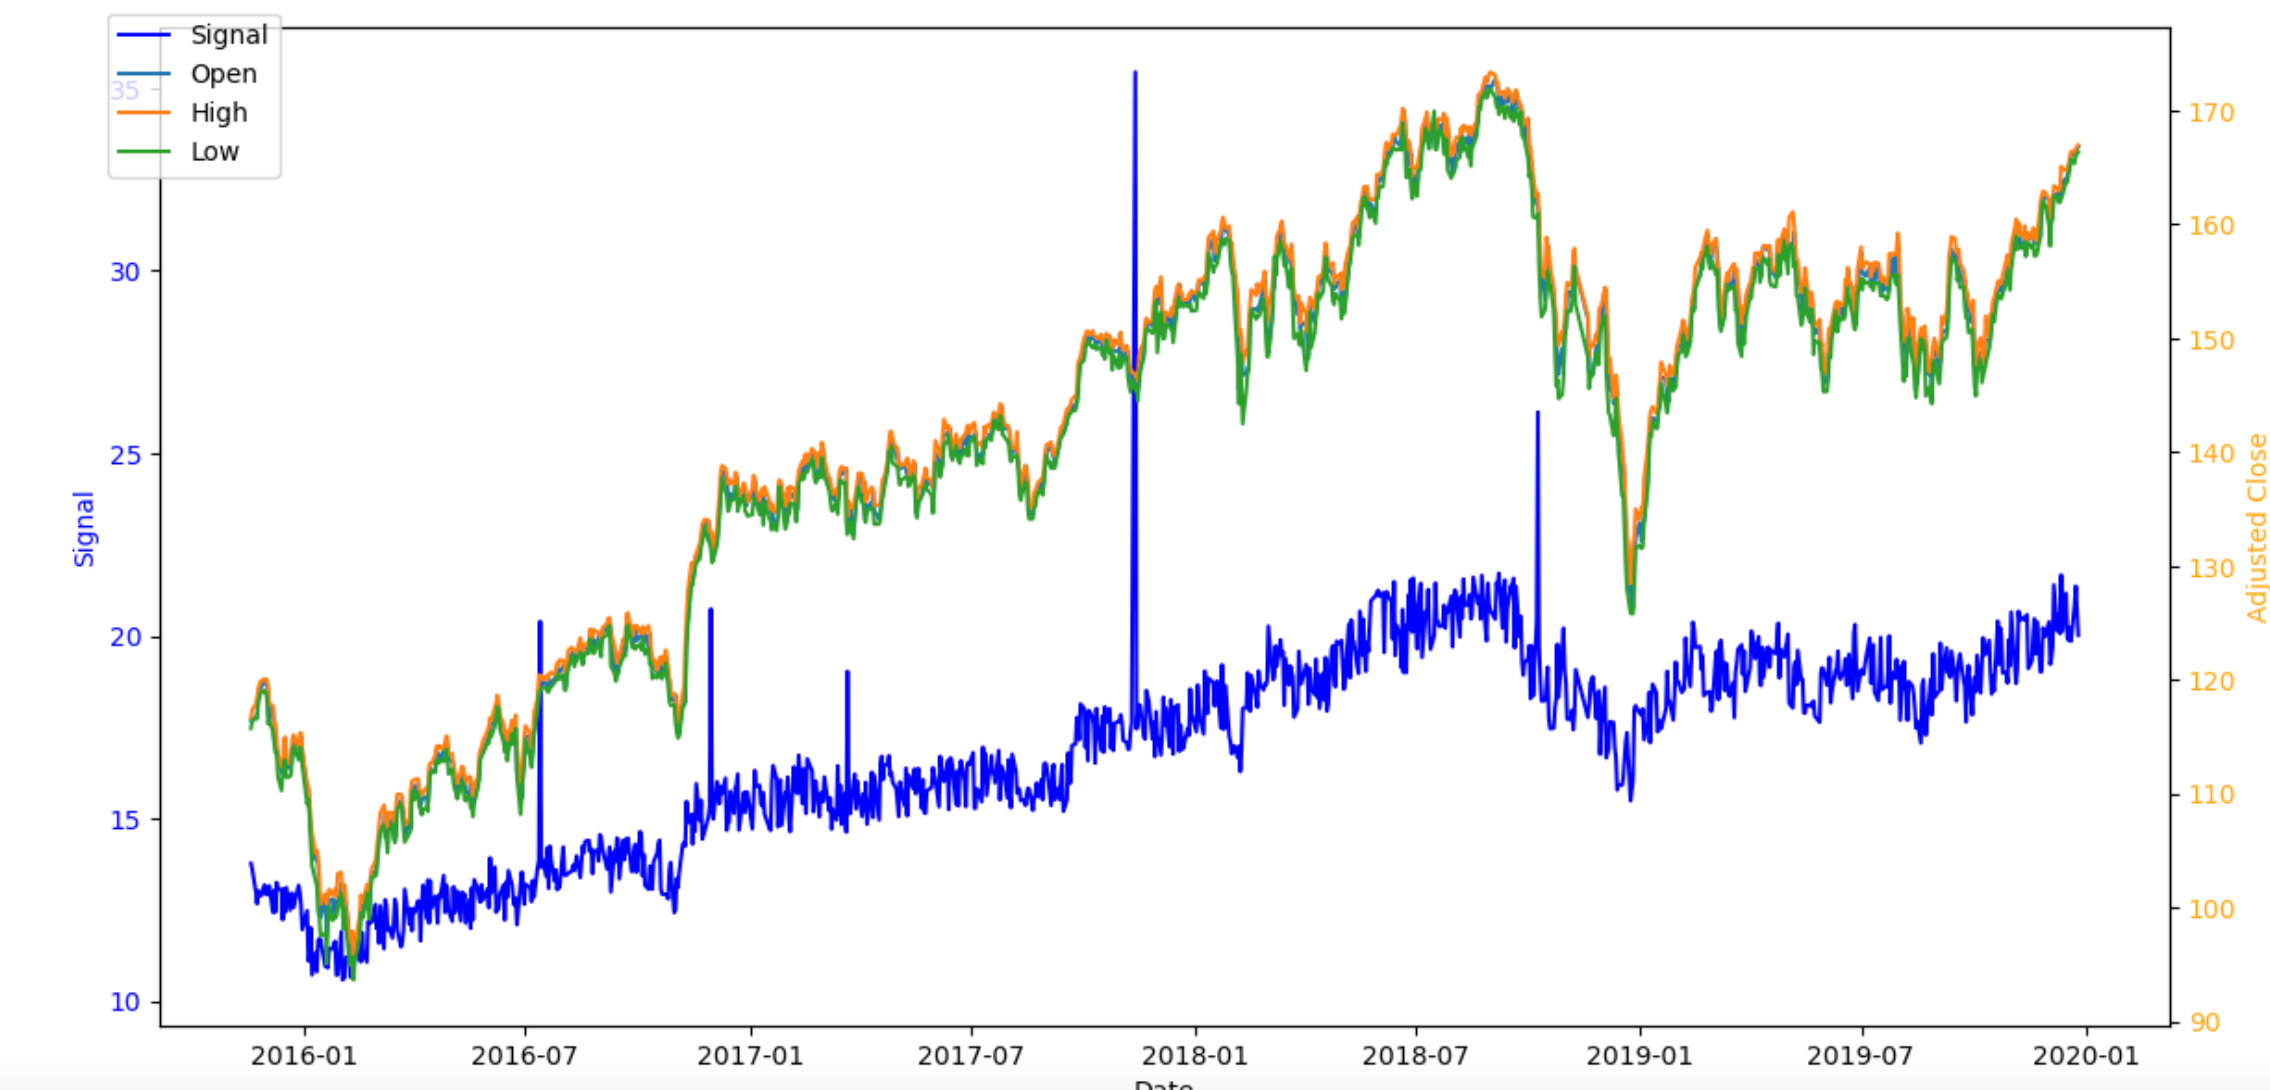

# picture: looks like they have same trend

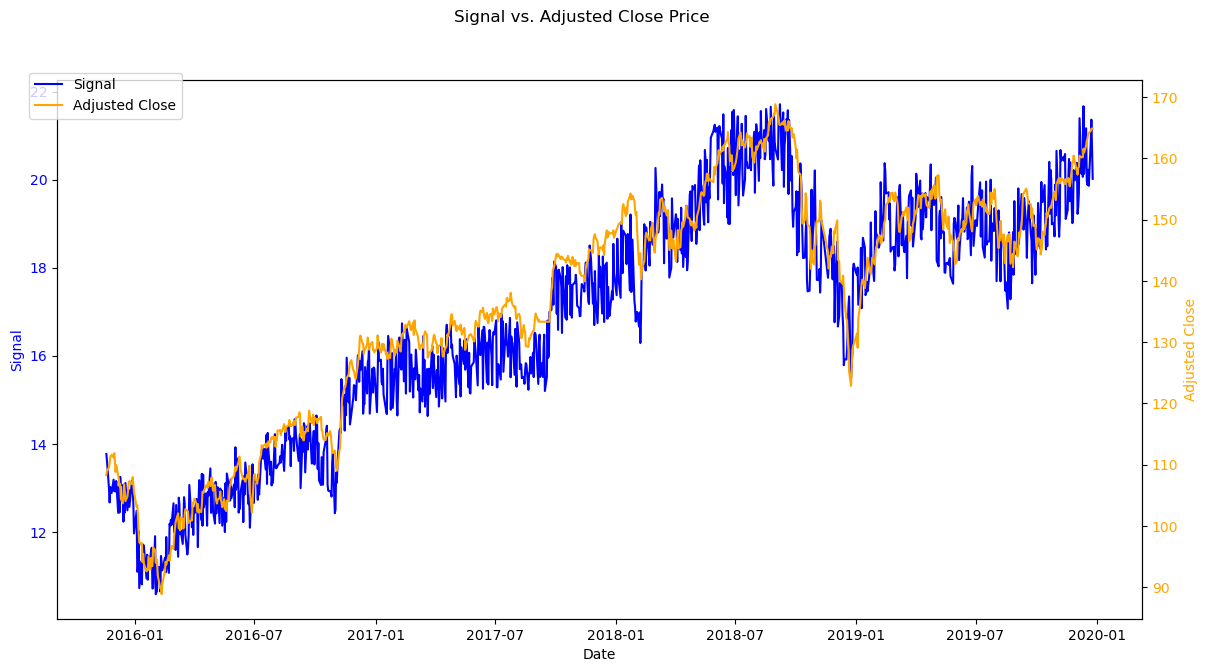

In [15]:
fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot the Signal on the primary y-axis
ax1.plot(df['Date'], df['Signal'], label='Signal', color='blue')
ax1.set_xlabel('Date')
ax1.set_ylabel('Signal', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a secondary y-axis and plot the Adjusted Close on it
ax2 = ax1.twinx()
ax2.plot(df['Date'], df['Adj Close'], label='Adjusted Close', color='orange')
ax2.set_ylabel('Adjusted Close', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title and a legend
fig.suptitle('Signal vs. Adjusted Close Price')
fig.legend(loc="upper left", bbox_to_anchor=(0.1,0.9))
plt.show()

# correlation

In [28]:
# Calculate the correlation between Signal and Adjusted Close
correlation = df['Signal'].corr(df['Adj Close'])
print(f"Correlation between Signal and Adjusted Close: {correlation}")

Correlation between Signal and Adjusted Close: 0.9645403011221056


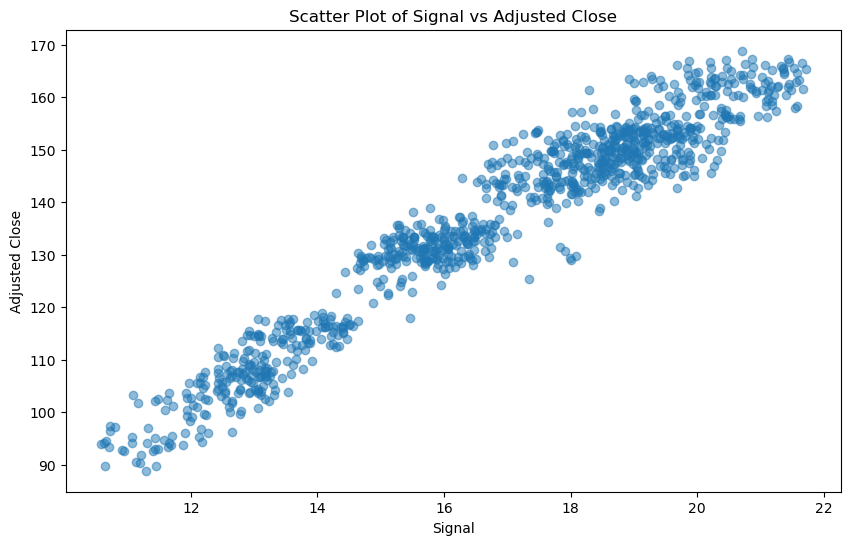

In [17]:
# Scatter plot of Signal vs Adjusted Close
plt.figure(figsize=(10, 6))
plt.scatter(df['Signal'], df['Adj Close'], alpha=0.5)
plt.xlabel('Signal')
plt.ylabel('Adjusted Close')
plt.title('Scatter Plot of Signal vs Adjusted Close')
plt.show()

## interpretation

1.clustered points:a consistent relationship between the signal and adjusted close prices within a certain range  
2.Outliers: unusual market conditions or errors in the data  
3.Trend Indication: could be leading indicator 

# further exploration

## 1.time lag analysis

In [29]:
# Create lagged signal columns
df['Signal_Lag1'] = df['Signal'].shift(1)
df['Signal_Lag2'] = df['Signal'].shift(2)
df['Signal_Lag3'] = df['Signal'].shift(3)

# Calculate correlation with different lags
correlation_lag1 = df['Signal_Lag1'].corr(df['Adj Close'])
correlation_lag2 = df['Signal_Lag2'].corr(df['Adj Close'])
correlation_lag3 = df['Signal_Lag3'].corr(df['Adj Close'])

print(f"Correlation with 1-day lag: {correlation_lag1}")
print(f"Correlation with 2-day lag: {correlation_lag2}")
print(f"Correlation with 3-day lag: {correlation_lag3}")

Correlation with 1-day lag: 0.9666939897270396
Correlation with 2-day lag: 0.9694044452123882
Correlation with 3-day lag: 0.9712275506673138


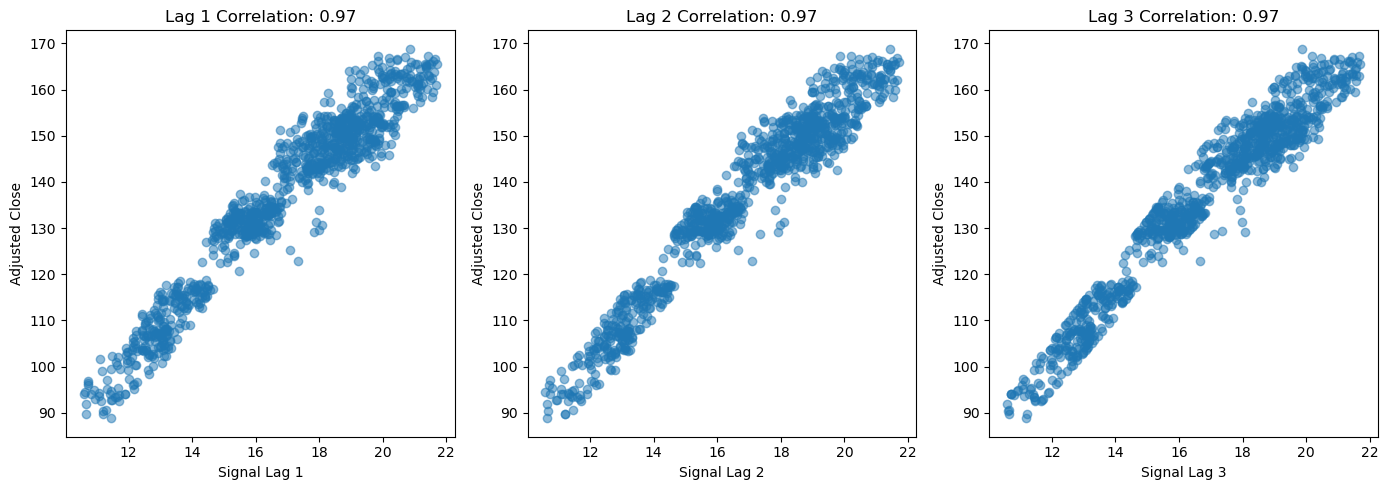

In [19]:
# Scatter plots for different lags
plt.figure(figsize=(14, 5))

plt.subplot(1, 3, 1)
plt.scatter(df['Signal_Lag1'], df['Adj Close'], alpha=0.5)
plt.xlabel('Signal Lag 1')
plt.ylabel('Adjusted Close')
plt.title(f'Lag 1 Correlation: {correlation_lag1:.2f}')

plt.subplot(1, 3, 2)
plt.scatter(df['Signal_Lag2'], df['Adj Close'], alpha=0.5)
plt.xlabel('Signal Lag 2')
plt.ylabel('Adjusted Close')
plt.title(f'Lag 2 Correlation: {correlation_lag2:.2f}')

plt.subplot(1, 3, 3)
plt.scatter(df['Signal_Lag3'], df['Adj Close'], alpha=0.5)
plt.xlabel('Signal Lag 3')
plt.ylabel('Adjusted Close')
plt.title(f'Lag 3 Correlation: {correlation_lag3:.2f}')

plt.tight_layout()
plt.show()

### determine the optimal lag

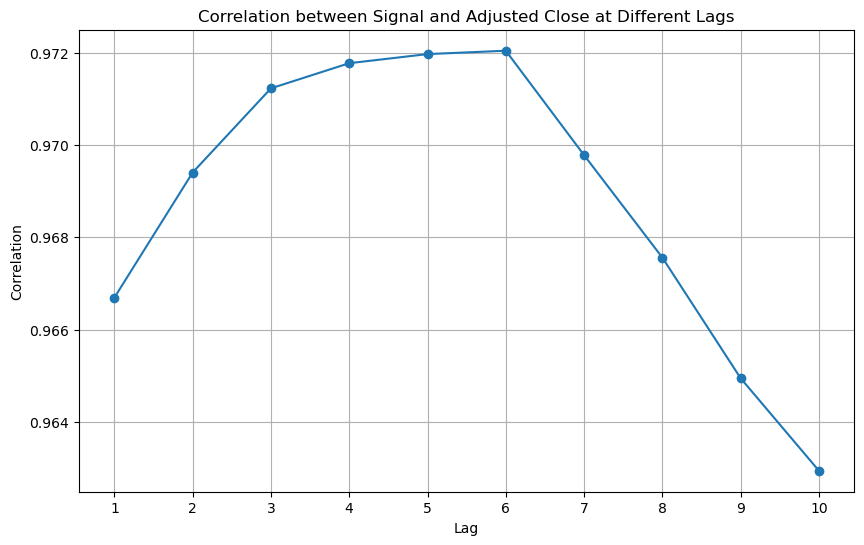

In [30]:
def calculate_lag_correlations(df, max_lag):
    correlations = []
    for lag in range(1, max_lag + 1):
        df[f'Signal_Lag{lag}'] = df['Signal'].shift(lag)
        correlation = df[f'Signal_Lag{lag}'].corr(df['Adj Close'])
        correlations.append(correlation)
    return correlations

# Calculate correlations for lags from 1 to 10
max_lag = 10
correlations = calculate_lag_correlations(df, max_lag)

# Plot correlation vs lag
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_lag + 1), correlations, marker='o')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.title('Correlation between Signal and Adjusted Close at Different Lags')
plt.xticks(range(1, max_lag + 1))
plt.grid(True)
plt.show()

### conclusion

1.Optimal Lag: The optimal lag appears to be around 5 days, where the correlation is highest (approximately 0.84). This suggests that the signal is most effective at predicting adjusted close prices 5 days into the future.  
2.Leading Indicator: The signal is confirmed as a leading indicator since it shows a strong and increasing correlation with future adjusted close prices up to the optimal lag.

##  2. Rolling Correlation:

### orgininal data

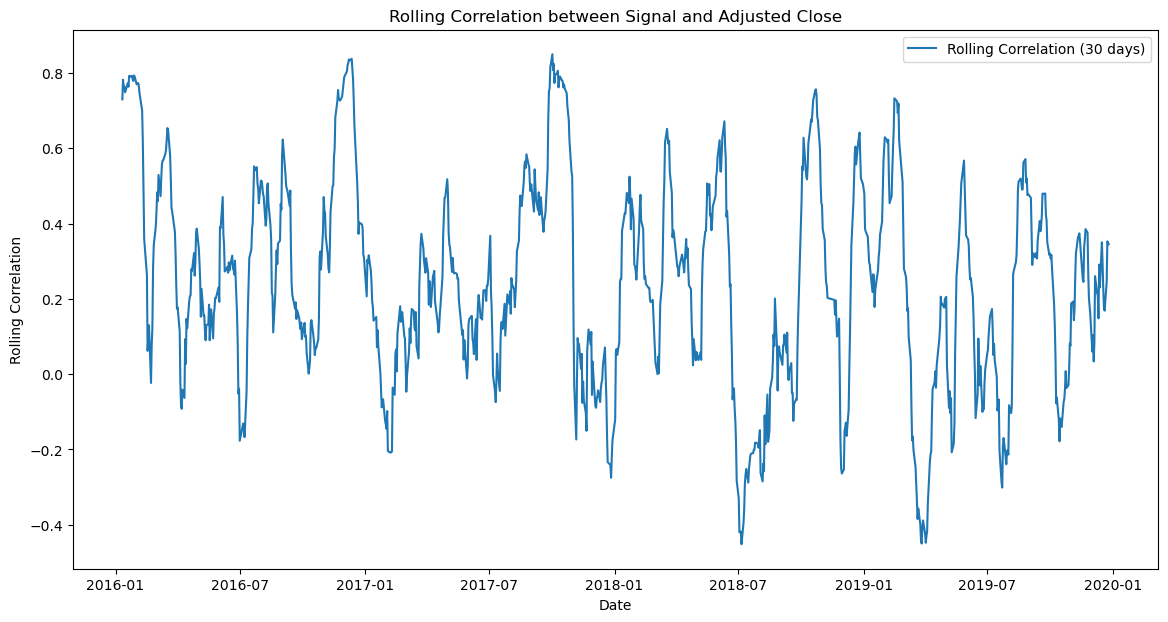

In [33]:
# Calculate rolling correlation
df['Rolling_Corr'] = df['Signal'].rolling(window=30).corr(df['Adj Close'])

# Plot rolling correlation
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Rolling_Corr'], label='Rolling Correlation (30 days)')
plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.title('Rolling Correlation between Signal and Adjusted Close')
plt.legend()
plt.show()

### lag 5

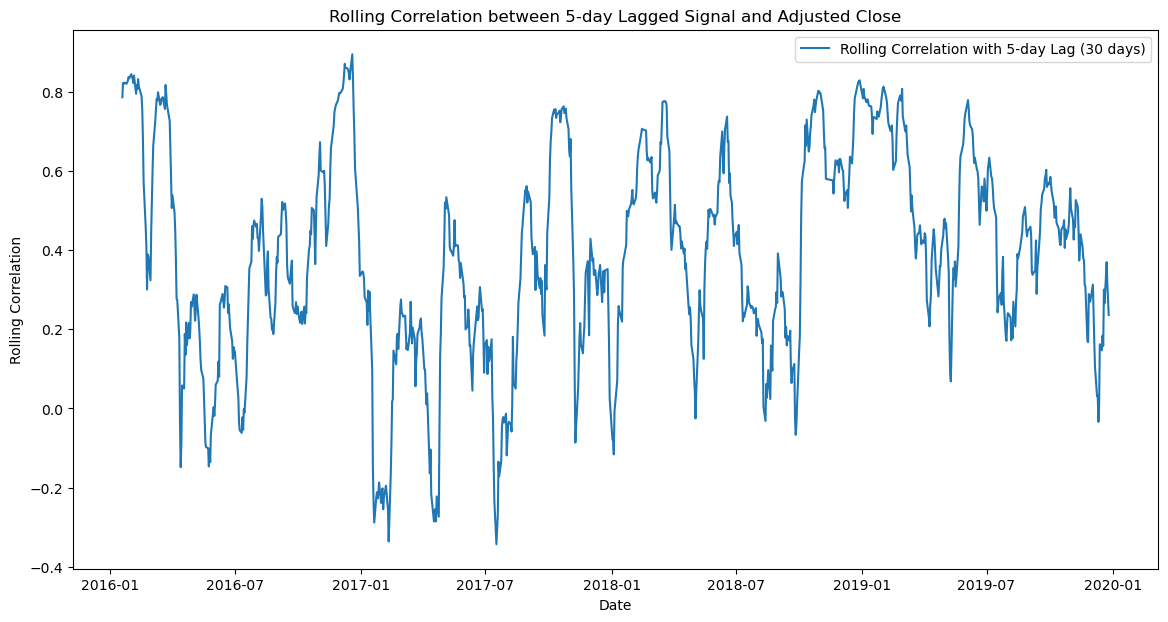

In [34]:
df['Signal_Lag5'] = df['Signal'].shift(5)
df['Rolling_Corr_Lag5'] = df['Signal_Lag5'].rolling(window=30).corr(df['Adj Close'])
plt.figure(figsize=(14, 7))
plt.plot(df['Date'], df['Rolling_Corr_Lag5'], label='Rolling Correlation with 5-day Lag (30 days)')
plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.title('Rolling Correlation between 5-day Lagged Signal and Adjusted Close')
plt.legend()
plt.show()

### compare

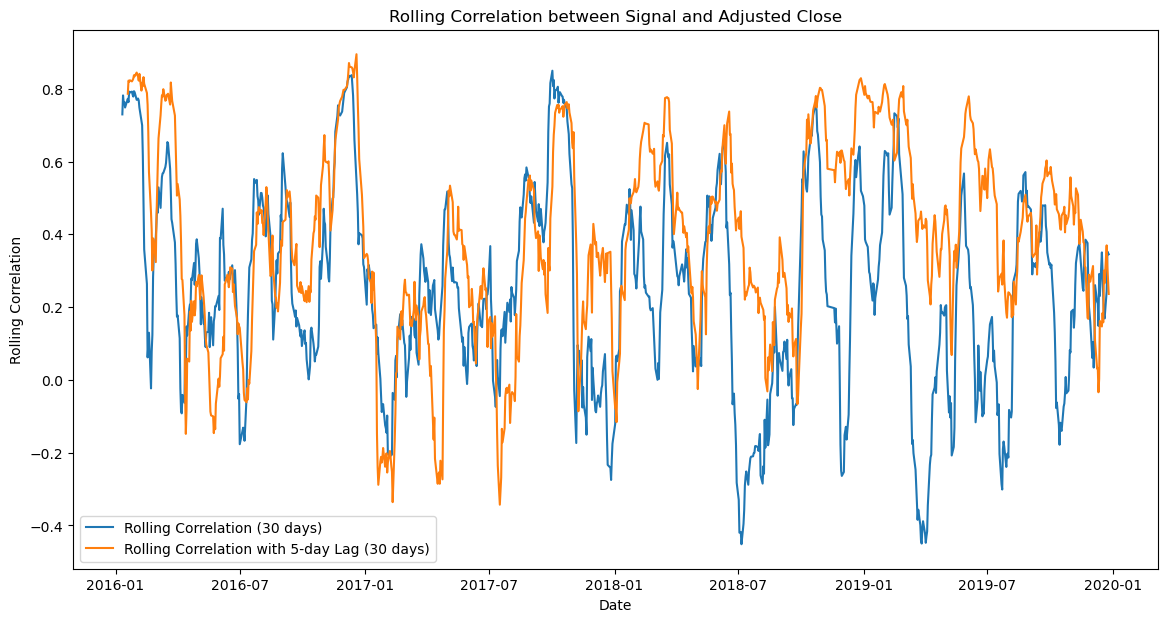

In [35]:
plt.figure(figsize=(14, 7))

# Plot rolling correlation with original signal
plt.plot(df['Date'], df['Rolling_Corr'], label='Rolling Correlation (30 days)')

# Plot rolling correlation with 5-day lagged signal
plt.plot(df['Date'], df['Rolling_Corr_Lag5'], label='Rolling Correlation with 5-day Lag (30 days)')

plt.xlabel('Date')
plt.ylabel('Rolling Correlation')
plt.title('Rolling Correlation between Signal and Adjusted Close')
plt.legend()
plt.show()

In [24]:
# Calculate summary statistics
original_mean = df['Rolling_Corr'].mean()
original_std = df['Rolling_Corr'].std()

lagged_mean = df['Rolling_Corr_Lag5'].mean()
lagged_std = df['Rolling_Corr_Lag5'].std()

print(f"Original Signal - Mean: {original_mean:.2f}, Std: {original_std:.2f}")
print(f"Lagged Signal (5 days) - Mean: {lagged_mean:.2f}, Std: {lagged_std:.2f}")


Original Signal - Mean: 0.24, Std: 0.28
Lagged Signal (5 days) - Mean: 0.39, Std: 0.26


## 3. Regression Analysis:

### original data

In [36]:
# Prepare the data for regression
X = df['Signal']
y = df['Adj Close']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Fit the regression model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.930
Model:                            OLS   Adj. R-squared:                  0.930
Method:                 Least Squares   F-statistic:                 1.369e+04
Date:                Thu, 30 May 2024   Prob (F-statistic):               0.00
Time:                        17:23:57   Log-Likelihood:                -3130.9
No. Observations:                1027   AIC:                             6266.
Df Residuals:                    1025   BIC:                             6276.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         22.1240      0.991     22.329      0.0

### lag5

In [37]:
# Create the 5-day lagged signal column
df['Signal_Lag5'] = df['Signal'].shift(5)

# Drop rows with NaN values generated by the lag
df = df.dropna(subset=['Signal_Lag5'])

# Prepare the data for regression
X = df['Signal_Lag5']
y = df['Adj Close']
X = sm.add_constant(X)  # Adds a constant term to the predictor

# Fit the regression model
model_lagged = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model_lagged.summary())

                            OLS Regression Results                            
Dep. Variable:              Adj Close   R-squared:                       0.945
Model:                            OLS   Adj. R-squared:                  0.945
Method:                 Least Squares   F-statistic:                 1.743e+04
Date:                Thu, 30 May 2024   Prob (F-statistic):               0.00
Time:                        17:24:20   Log-Likelihood:                -2995.5
No. Observations:                1022   AIC:                             5995.
Df Residuals:                    1020   BIC:                             6005.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          21.4881      0.884     24.313      

### compare

1.R-squared and Adjusted R-squared:The 5-day lagged signal model has a higher R-squared and adjusted R-squared, indicating that it explains a greater proportion of the variance in the adjusted close prices  
2.F-statistic and p-value:The F-statistic is higher for the lagged signal model, and both models have very low p-values, indicating strong overall significance. The higher F-statistic for the lagged signal model suggests a better fit.  
3.Coefficients:The coefficient for the lagged signal (6.1547) is higher than the original signal (4.9595), suggesting a stronger relationship with adjusted close prices.  
4.Standard Errors:The standard error for the lagged signal coefficient is slightly lower, indicating more precision in the estimate.  
5.Diagnostics (Omnibus, Jarque-Bera, etc.): Both models show signs of non-normality in the residuals (high skew and kurtosis, significant Omnibus and Jarque-Bera test results). This might indicate that further diagnostics or alternative modeling techniques could be beneficial.  

### potential reasons for Non-Normality

1.Outliers:Extreme values can skew the distribution of residuals, leading to non-normality. Outliers can disproportionately influence the model, distorting estimates and reducing predictive accuracy.**could be**  
2.Model Misspecification:The functional form of the model may be incorrect. For instance, if the relationship between the independent and dependent variables is non-linear, a simple linear model will not capture it accurately, leading to non-normal residuals.**probabaly not, as the scatter graph shows lienar relationship**  
3.Heteroscedasticity:Variability of residuals may change across different levels of the independent variable(s). This violates another assumption of linear regression, which assumes constant variance of residuals (homoscedasticity).**could be**  
4.Omitted Variable Bias:Important predictors may be missing from the model, resulting in biased and non-normally distributed residuals.**not sure, but from this project persepctive, it won't need to consider**  